# Study of data variability with bootstrap

data = $P_{load}$ and $P_{sun}$ series (the two inputs of the solar home benchmark)

Questions this notebook should answer:
* what is the variability of important statistics (like cumulated energy) ?
* how is this varibility dependant on the length of time series?
* in the end, what is an appropriate choice of the **length of test data**?

Also, at the end of the notebook, there is the code to generate the bootstrapped samples of the test data (`test-data_2011-11-29_33-days_bl-3_bs-400.csv`)

Pierre Haessig, April 2018

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

## 0) Load testcase data

In [2]:
E_rated = 10 # kWh
P_pvp = 3 # kW
P_grid_max = 3 # kW

In [3]:
df = pd.read_csv('../data/data_2011-2012.csv', index_col=0, parse_dates=True)

# slice test weeks
#df = df['2011-11-29':'2011-12-05'] # 1 week
#df = df['2011-11-29':'2011-12-12'] # 2 weeks
#df = df['2011-11-29':'2011-12-19'] # 3 weeks
#df = df['2011-11-29':'2011-12-26'] # 4 weeks
df = df['2011-11-29':'2011-12-31'] # 33 days, almost 5 weeks

n = len(df)
n//48

33

In [4]:
P_load = df.GC
P_sun = df.GG/1.04*P_pvp;

dt = 0.5 # hours
t = np.arange(n)*dt # hours
td = t/24 #days

In [5]:
print('Data from {} to {} ({:.0f} days)'. format(df.index.date[0], df.index.date[-1], n//48))
print('* average sun energy: {:.2f} kWh/d'.format(P_sun.mean()*24))
print('* average load      : {:.2f} kWh/d'.format(P_load.mean()*24))
print('* ratio sun/load: {:.2%}'.format(P_sun.mean()/P_load.mean()))

Data from 2011-11-29 to 2011-12-31 (33 days)
* average sun energy: 12.00 kWh/d
* average load      : 16.76 kWh/d
* ratio sun/load: 71.64%


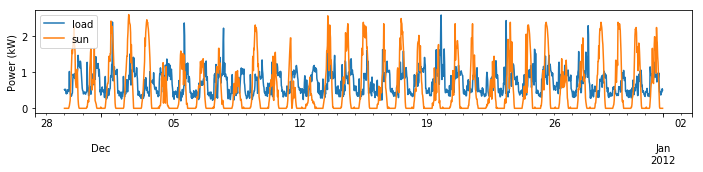

In [6]:
fig = plt.figure(figsize=(10,2.5))
P_load.plot(label='load')
P_sun.plot(label='sun')
plt.legend()
plt.ylabel('Power (kW)')
fig.tight_layout()

Quick comparison of solar pattern evolution (data stationnarity over the test set):

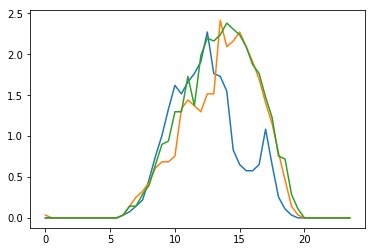

In [7]:
plt.plot(np.arange(48)*dt, P_sun['2011-11-29']);
plt.plot(np.arange(48)*dt, P_sun['2011-12-01']);
plt.plot(np.arange(48)*dt, P_sun['2011-12-28']);

## Data bootstrap

Generate bootstrapped samples of the input time series. The bootstrap procedure has to take into account two aspects:

* strong data seasonality (daily pattern)
* potential persistence between days

In [8]:
def seasonal_block_bootstrap(X, nsamp, slen, blen=1):
    '''Generate `ns` bootstrapped samples of the seasonal multivariate time series `X`
    
    when sampling blocks near the end of the timeseries, circular indexing is used
    (the beginning of the data is repeated after the end)
    
    Parameters
    ----------
    X: 2D array of shape (n, nvars)
        multivariate time series of length `n`, made of `nvars` variables
    nsamp: int
        desired number of bootstrapped samples
    slen: int
        season length, as a number of samples. time series length `n` must be a multiple of `slen`
    blen: int, optional
        block length for bootstrapping, as a number of seasons,
        so that the actual block length is blen*slen samples.
        Defaults to 1.
    
    Returns
    -------
    Xb_list: list of 2D arrays
        list of `ns` bootstrapped samples, which are arrays with same shape as X
    '''
    # time series length:
    n = X.shape[0]
    nvars = X.shape[1]
    assert n%slen == 0, 'time series length should be a multiple of season length'
    # nb of seasons
    nseas = n//slen
    
    blen = blen*slen # nb seasons -> nb samples
    assert blen < n, 'block length should be smaller than the length of the time series'
    
    # augmented timeseries, with beginning pasted at the end (circling indexing)
    Xaug = np.vstack([X, X[:blen, :]])
    
    # number of blocks needed
    nblocks = int(np.ceil(n/blen))
    
    Xb_list = []
    
    for i in range(nsamp):
        # output, before cropping
        Xb = np.zeros((nblocks*blen, nvars))

        for k in range(nblocks):
            # take a random slice of length blen
            i0 = np.random.randint(0, nseas-1) * slen # slice start
            Xk = Xaug[i0:i0+blen, :]
            # paste slice in output
            Xb[k*blen:(k+1)*blen, :] = Xk
        # output cropped to the size of X
        Xb_list.append(Xb[:n, :])
    return Xb_list

### a) Test bootstrap method

In [9]:
X = np.vstack([P_load, P_sun]).T
X.shape

(1584, 2)

In [10]:
# number of samples
nsamp = 2

np.random.seed(0)
Xb_list = seasonal_block_bootstrap(X[:48*7,:], nsamp, 48, 3)
Xb_list[0].shape

(336, 2)

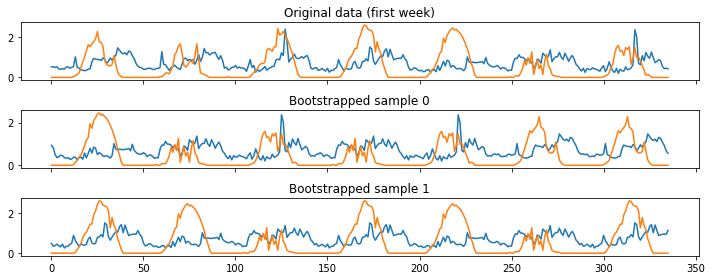

In [11]:
fig, ax = plt.subplots(3,1, sharex=True, figsize=(10,4))
ax[0].plot(X[:48*7,:])
ax[0].set_title('Original data (first week)')

ax[1].plot(Xb_list[0])
ax[1].set_title('Bootstrapped sample 0')

ax[2].plot(Xb_list[1])
ax[2].set_title('Bootstrapped sample 1')

fig.tight_layout()

## 2) Statistics on bootstrapped samples

Main objective of this notebook: study the effect of data variability on the variability of the test bench results

### a) Manual exploration

two choices: block size, length of the sample

In [12]:
# number of samples
nsamp = 300
print('nb of data points to generate: {:.1f} k'.format(nsamp * X.size/1000))

nb of data points to generate: 950.4 k


Choose the block size:

In [13]:
# block size (as nb of days)
blen = 5
np.random.seed(0)
Xb_list = seasonal_block_bootstrap(X, nsamp, 48, blen)

Cumulated energy for each sample (for load and for sun)

In [14]:
# truncate samples to see the effect of the sample length
ndays = 21

X_cumen = np.zeros((len(Xb_list), 2))
for k, Xb in enumerate(Xb_list):
    # truncate:
    Xb = Xb[:ndays*48,:]
    X_cumen[k,:] = Xb.mean(axis=0)*24 # kWh/day

P_load_cumen = X_cumen[:,0]
P_sun_cumen = X_cumen[:,1]
P_nl_cumen = P_load_cumen - P_sun_cumen

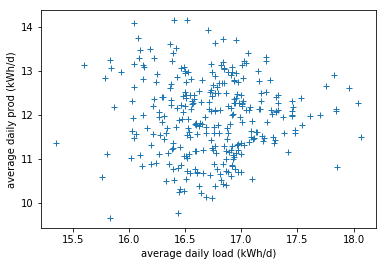

In [15]:
plt.plot(P_load_cumen, P_sun_cumen, '+')
plt.xlabel('average daily load (kWh/d)');
plt.ylabel('average daily prod (kWh/d)');

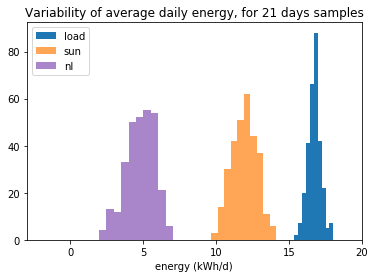

In [16]:
plt.title('Variability of average daily energy, for {} days samples'.format(ndays))
plt.hist(P_load_cumen, label='load')
plt.hist(P_sun_cumen, alpha=0.7, label='sun')
plt.hist(P_nl_cumen, color='tab:purple', alpha=0.8, label='nl')
plt.legend()
plt.xlabel('energy (kWh/d)')
plt.xlim(-3, 20);
#plt.savefig('var_daily_ener_d{}.png'.format(ndays), dpi=150)

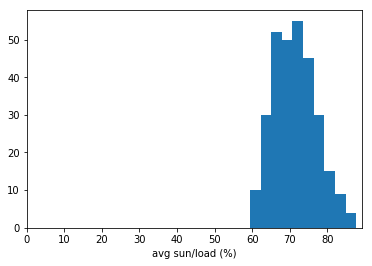

In [17]:
plt.hist(P_sun_cumen/P_load_cumen*100);
plt.xlim(xmin=0)
plt.xlabel('avg sun/load (%)');

### a) Effect of sample length

idea: truncate the bootstrapped time series to see the effect of length

(for a given block size)

In [18]:
# number of samples
nsamp = 300
# block size (as nb of days)
blen = 3
np.random.seed(0)
Xb_list = seasonal_block_bootstrap(X, nsamp, 48, blen)

In [19]:
ndays_list = np.array([1, 2, 3, 4, 5, 7, 10, 14, 21, 33])

std_ndays = []

for ndays in ndays_list:
    X_cumen = np.zeros((len(Xb_list), 2))
    for k, Xb in enumerate(Xb_list):
        # truncate:
        Xb = Xb[:ndays*48,:]
        X_cumen[k,:] = Xb.mean(axis=0)*24 # kWh/day
    P_load_cumen = X_cumen[:,0]
    P_sun_cumen = X_cumen[:,1]
    P_nl_cumen = P_load_cumen - P_sun_cumen
    
    cumen_std = P_load_cumen.std(), P_sun_cumen.std(), P_nl_cumen.std()
    std_ndays.append(cumen_std)
    
std_ndays = pd.DataFrame(data=std_ndays, index=ndays_list, columns=['load', 'sun', 'nl'])
std_ndays.index.name = 'ndays'

std_ndays.tail(2)

,load,sun,nl
ndays,,,
21,0.501372,0.901066,1.051489
33,0.424413,0.732648,0.896448


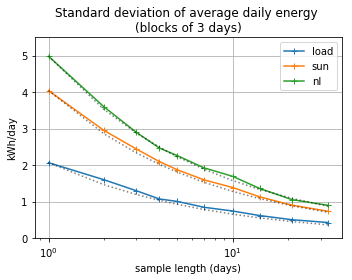

In [20]:
fig, ax = plt.subplots(figsize=(5,4))

std_ndays.plot(style='+-', ax=ax)
ax.plot(ndays_list, std_ndays.load[1]/np.sqrt(ndays_list), 'k:', alpha=0.5)
ax.plot(ndays_list, std_ndays.sun[1]/np.sqrt(ndays_list), 'k:', alpha=0.5)
ax.plot(ndays_list, std_ndays.nl[1]/np.sqrt(ndays_list), 'k:', alpha=0.5)

ax.set(
    title='Standard deviation of average daily energy \n(blocks of {} days)'.format(blen),
    xlabel='sample length (days)',
    xscale='log',
    #yscale='log',
    ylabel='kWh/day',
    ylim=(0, 5.5)
)
ax.grid(True)

fig.tight_layout()

#plt.savefig('std_daily_ener_bl{}.png'.format(blen), dpi=150)

Effect of sample length: the variability decreases more or less a $1/\sqrt{n_{days}}$. Using 30 days enables a standard deviation of average net load below 1 kWh/day (to be compared to the mean ~ 5 kWh/d) 

Conclusion on block size: it is not clear to me how to set the block length for the bootstrap. There seems to be a tradeoff:

* short blocks (1-2 days):
  * `-` it necessarily kills the potential correlation between successive days.
  * `+` many different potential samples (ndays^nblocks)
* long blocks (5 days or more?):
  * `+` preserves the potential correlation between successive days.
  * `-` few potential different samples, so that the boot strapped statistics have a strong variability, despite the 300 samples

  

## Save bootstrapped samples

(for other analysis, e.g. the sensitivity of benchmark results)

the following cells are a gathering of cells used throughout the notebook, but applying bootstrap procedure is applied from scratch. 

Also, for in this datafile, the rated PV power correction is not applied, like in the original dataset. 

In [22]:
df = pd.read_csv('../data/data_2011-2012.csv', index_col=0, parse_dates=True)

# slice test weeks:
df = df['2011-11-29':'2011-12-31'] # 33 days, almost 5 weeks
n = len(df)
n//48 # days

33

In [23]:
P_load = df.GC
P_sun = df.GG #/1.04*P_pvp; no rated PV power correction

X = np.vstack([P_load, P_sun]).T
X.shape

(1584, 2)

In [24]:
# number of samples
nsamp = 400
print('nb of data points to generate: {:.1f} k'.format(nsamp * X.size/1000))

nb of data points to generate: 1267.2 k


In [25]:
# block size (as nb of days)
blen = 3
np.random.seed(0)
Xb_list = seasonal_block_bootstrap(X, nsamp, 48, blen)

In [26]:
Xb_stacked = np.hstack(Xb_list)
# plt.plot(Xb_stacked[:48*7, :4]) # check
Xb_stacked.shape

(1584, 800)

In [28]:
fname = 'test-data_{}_{:.0f}-days_bl-{}_bs-{}.csv'.format(
        df.index.date[0], n//48, blen, len(Xb_list))
fname

'test-data_2011-11-29_33-days_bl-3_bs-400.csv'

In [43]:
#cols = (['P_load_%d' % k, 'P_sun_%d' % k] for k in range(nsamp))
cols = (['GC%d' % k, 'GG%d' % k] for k in range(nsamp))
cols = sum(cols, [])
cols[:4]

['GC0', 'GG0', 'GC1', 'GG1']

In [42]:
df_bs = pd.DataFrame(Xb_stacked, index = df.index, columns=cols)
df_bs.head(3)

,GC0,GG0,GC1,GG1,GC2,GG2,GC3,GG3,GC4,GG4,...,GC395,GG395,GC396,GG396,GC397,GG397,GC398,GG398,GC399,GG399
2011-11-29 00:00:00,0.468,0.0,0.456,0.0,0.338,0.0,0.538,0.0,0.510,0.0,...,0.494,0.0,0.482,0.0,0.510,0.0,0.358,0.0,0.586,0.0
2011-11-29 00:30:00,0.504,0.0,0.502,0.0,0.366,0.0,0.620,0.0,0.538,0.0,...,0.318,0.0,0.344,0.0,0.538,0.0,0.352,0.0,0.404,0.0
2011-11-29 01:00:00,0.394,0.0,0.500,0.0,0.568,0.0,0.510,0.0,0.448,0.0,...,0.326,0.0,0.376,0.0,0.448,0.0,0.268,0.0,0.574,0.0


In [44]:
df_bs.to_csv(fname, float_format='%.6g')
print(fname + ' written!')

test-data_2011-11-29_33-days_bl-3_bs-400.csv written!
